This notebook was meant to contain the graphs to be used for the presentation of the 3 July 2023, with people from the sub project from Gorongosa.

Plots to do, with only temperature and precipitation for the moment:

>Compare historic observed v historic model​

>Compare WB v downscaled/bc data​

>Create overview of trends (monthly, annual evolution)​

>Compare historic model v historic projection​ (some analysis require separation of SSPs / model uncertainty)

>Taste of indicators:​

>SSP3: days above 40C (over time)​

>100yr precipitation​

In [1]:
emplacement_of_int = 'Gorongosa'

start_year_hist = 1980
stop_year_hist = 2014

tuple_error_bar = ('pi',80) # default one is confidence interval of 95%


In [2]:
# packages
import pandas as pd
import numpy as np
import os
import os.path
import seaborn as sns
import matplotlib
import geopy.distance
from matplotlib import pyplot as plt

In [3]:
# functions

def import_treat_modeled_NEX_GDDP_CMIP6(climate_var, unit):
    # import data
    
    path_NEX_GDDP_CMIP6_EmplacementStation=os.path.join(r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file',climate_var,climate_var+'_'+unit+'_day_1950-2100',climate_var+'_1950-2100_projectsMoz.csv')
    
    data_NEX_GDDP_CMIP6_EmplacementStation = pd.read_csv(path_NEX_GDDP_CMIP6_EmplacementStation)
    
    data_NEX_GDDP_CMIP6_EmplacementStation = add_year_month_season(data_NEX_GDDP_CMIP6_EmplacementStation,'Date')
    
    return data_NEX_GDDP_CMIP6_EmplacementStation

In [4]:
def add_year_month_season(df,column_date):
    # add Year, month and season columns for graphs
    Year = df[[column_date]].values.reshape(len(df[[column_date]].values),)
    Month = df[[column_date]].values.reshape(len(df[[column_date]].values),)
    Season = df[[column_date]].values.reshape(len(df[[column_date]].values),)
    
    if str(Year[1]).find('-')==2:
        for i in np.arange(0,len(df[[column_date]].values)):
            Year[i]=int(Year[i][6:10])
            Month[i]=int(Month[i][3:5])
            if Month[i]>3 and Month[i]<10: # dry season in Mozambique is between April and September
                Season[i]='Dry'
            else:# humid season is between October and March
                Season[i]='Humid'
            
            Month[i]=str_month(Month[i])
            
    if str(Year[1]).find('-')==4:
        for i in np.arange(0,len(df[[column_date]].values)):
            Year[i]=int(Year[i][0:4])
            Month[i]=int(Month[i][5:7])
            if Month[i]>3 and Month[i]<10: # dry season in Mozambique is between April and September
                Season[i]='Dry'
            else:# humid season is between October and March
                Season[i]='Humid'
            
            Month[i]=str_month(Month[i])
                
    df['Year'] = Year
    df['Month'] = Month
    df['Season'] = Season
    return df

In [5]:
def str_month(int_m):
    if int_m==1:
        str_m = 'Jan'
    if int_m==2:
        str_m = 'Feb'    
    if int_m==3:
        str_m = 'Mar'
    if int_m==4:
        str_m = 'Apr'
    if int_m==5:
        str_m = 'May'
    if int_m==6:
        str_m = 'Jun'
    if int_m==7:
        str_m = 'Jul'
    if int_m==8:
        str_m = 'Aug'    
    if int_m==9:
        str_m = 'Sep'
    if int_m==10:
        str_m = 'Oct'
    if int_m==11:
        str_m = 'Nov'
    if int_m==12:
        str_m = 'Dec'
    return str_m

In [6]:
# this function is meant to find which meteo stations are the closest to the projects of interest
# find which stations are of interest, which one are the closest to the coordinates of the projects
def find_closest_meteo_station_to_projects(data_obs_NOAA,name_projects,lat_projects,lon_projects):
    # save in a dataframe name, latitudes and longitudes informations for each station
    df_station_NOAA=data_obs_NOAA.loc[:, ["NAME", "LATITUDE","LONGITUDE"]]
    df_station_NOAA.drop_duplicates(inplace = True) # drop duplicates to only have name of the towns and latitudes and longitudes
    df_station_NOAA.reset_index(drop=True,inplace = True)  # drop = true avoids to keep the former index
    # inplace = True modifies the original dataframe
    
    name_closest_station_to_project = [] # create an empty list to contain the name of the closest station to each project
    index_closest_station_to_project = []
    for (i,name_project) in zip(np.arange(0,len(name_projects)),name_projects):
        # calculate difference between the different coordinates
        df_station_NOAA['Diff latitude project '+str(i)] = abs(abs(df_station_NOAA['LATITUDE']) - abs(lat_projects[i]))
        df_station_NOAA['Diff longitude project '+str(i)] = abs(abs(df_station_NOAA['LONGITUDE']) - abs(lon_projects[i]))
        df_station_NOAA['Diff coordinates project '+str(i)] = df_station_NOAA['Diff latitude project '+str(i)]+df_station_NOAA['Diff longitude project '+str(i)]
        # register the name of the stations that are the closest to the projects and the index in df_station_NOAA corresponding to those closest stations
        name_closest_station = df_station_NOAA['NAME'].iloc[np.where(df_station_NOAA['Diff coordinates project '+str(i)]==min(df_station_NOAA['Diff coordinates project '+str(i)]))[0][0]]
        name_closest_station_to_project.append(name_closest_station)
        index_closest_station_to_project.append(np.where(df_station_NOAA['Diff coordinates project '+str(i)]==min(df_station_NOAA['Diff coordinates project '+str(i)]))[0][0])
        print('The closest meteorological station to the project '+name_project+' is the one located in '+name_closest_station)

        #coords_1 = (df_station_NOAA['LATITUDE'][index_closest_station_to_project], df_station_NOAA['LONGITUDE'][index_closest_station_to_project])
        #coords_2 = (lat_projects[i], lon_projects[i])
        #str_dist = str(geopy.distance.geodesic(coords_1, coords_2).km)
        #print('The distance between the station '+ df_station_NOAA['NAME'][index_closest_station_to_project] +' and the emplacement of interest '+name_projects[i]+' is '+str_dist+ ' km.')

    # take off the duplicates from the list of name of station which are the closest to our projects and the indexes in the dataframe of those corresponding stations
    name_closest_station_to_project_without_duplicates=list(set(name_closest_station_to_project))
    index_closest_station_to_project_without_duplicates=list(set(index_closest_station_to_project))
    print('\n')
    print('The coordinates for the meteorological stations which are the closest to the project of interest are :')
    print('\n')
    for k in np.arange(len(index_closest_station_to_project_without_duplicates)):
        print('Name '+df_station_NOAA['NAME'][index_closest_station_to_project_without_duplicates[k]])
        print('Longitude '+str(df_station_NOAA['LONGITUDE'][index_closest_station_to_project_without_duplicates[k]]))
        print('Latitude '+str(df_station_NOAA['LATITUDE'][index_closest_station_to_project_without_duplicates[k]]))
        print('\n')

In [7]:
coords_1 = (2,3)
coords_2 = (4,5)
str(geopy.distance.geodesic(coords_1, coords_2).km)

'313.5883972125955'

# Import data

## Observations data
precipitation: NOAA, gorongosa

temperature: NOAA

### Precipitation: NOAA

In [8]:
path = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\NOAA-ClimateDataOnline\3370204.csv'
daily_sum_obs_from_NOAA = pd.read_csv(path)

In [9]:
# find closest station to the station of interest
name_projects_data = np.array(['Gorongosa'])
name_projects = pd.Series(name_projects_data)

lon_projects_data = np.array([34.07824286310398])
lon_projects = pd.Series(lon_projects_data)

lat_projects_data = np.array([-18.68063728746643])
lat_projects = pd.Series(lat_projects_data)

#find_closest_meteo_station_to_projects(daily_sum_obs_from_NOAA,name_projects,lat_projects,lon_projects)

In [138]:
daily_sum_obs_from_NOAA_gorongosa = daily_sum_obs_from_NOAA[daily_sum_obs_from_NOAA['NAME']=='CHIMOIO, MZ']
daily_sum_obs_from_NOAA_gorongosa = add_year_month_season(daily_sum_obs_from_NOAA_gorongosa,'DATE')
daily_sum_obs_from_NOAA_gorongosa

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = Year
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = Month
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season
3019,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-01,0.4,",,Q",NaN,NaN,30.0,",,Q",20.7,",,Q",1970,Jan,Humid
3020,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-02,0.0,",,Q",NaN,NaN,30.5,",,Q",21.2,",,Q",1970,Jan,Humid
3021,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-03,0.0,",,Q",NaN,NaN,28.7,",,Q",20.5,",,Q",1970,Jan,Humid
3022,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-04,0.0,",,Q",NaN,NaN,28.8,",,Q",19.2,",,Q",1970,Jan,Humid
3023,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-05,0.0,",,Q",NaN,NaN,30.1,",,Q",20.2,",,Q",1970,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16615,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-27,NaN,NaN,25.3,"H,,S",NaN,NaN,21.2,",,S",2020,Dec,Humid
16616,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-28,NaN,NaN,26.4,"H,,S",NaN,NaN,21.3,",,S",2020,Dec,Humid
16617,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-29,NaN,NaN,25.9,"H,,S",NaN,NaN,NaN,NaN,2020,Dec,Humid
16618,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-30,7.1,",,S",22.8,"H,,S",NaN,NaN,21.0,",,S",2020,Dec,Humid


In [11]:
daily_sum_obs_from_NOAA_gorongosa

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season
3019,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-01,0.4,",,Q",NaN,NaN,30.0,",,Q",20.7,",,Q",1970,Jan,Humid
3020,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-02,0.0,",,Q",NaN,NaN,30.5,",,Q",21.2,",,Q",1970,Jan,Humid
3021,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-03,0.0,",,Q",NaN,NaN,28.7,",,Q",20.5,",,Q",1970,Jan,Humid
3022,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-04,0.0,",,Q",NaN,NaN,28.8,",,Q",19.2,",,Q",1970,Jan,Humid
3023,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1970-01-05,0.0,",,Q",NaN,NaN,30.1,",,Q",20.2,",,Q",1970,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16615,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-27,NaN,NaN,25.3,"H,,S",NaN,NaN,21.2,",,S",2020,Dec,Humid
16616,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-28,NaN,NaN,26.4,"H,,S",NaN,NaN,21.3,",,S",2020,Dec,Humid
16617,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-29,NaN,NaN,25.9,"H,,S",NaN,NaN,NaN,NaN,2020,Dec,Humid
16618,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2020-12-30,7.1,",,S",22.8,"H,,S",NaN,NaN,21.0,",,S",2020,Dec,Humid


How much precipitation data are we missing in those data coming from NOAA ?

In [12]:
def countna(data):
    return data.isna().sum()

In [13]:
na_values_daily_sum_obs_from_NOAA_gorongosa_PRCP=daily_sum_obs_from_NOAA_gorongosa[['PRCP','Year']].groupby(['Year']).agg(countna).reset_index()

In [14]:
len(daily_sum_obs_from_NOAA_gorongosa['PRCP'])

13601

In [15]:
print('The missing value represent '+str((daily_sum_obs_from_NOAA_gorongosa['PRCP'].isna().sum()/len(daily_sum_obs_from_NOAA_gorongosa['PRCP']))*100)+' % of the total')

The missing value represent 34.725387839129475 % of the total


### Precipitation : observation from Gorongosa

Observation precipitation data given by André Görgens (Cosnultant, Water resources Management, Zutari) in an email, on the 20th of June 2023.

In [16]:
path = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\DirecltyfromMoz\Precipitation_Gorongosa_reformat.csv'
pr_obs_gorongosa_from_gorongosa = pd.read_csv(path)

In [17]:
pr_obs_gorongosa_from_gorongosa=add_year_month_season(pr_obs_gorongosa_from_gorongosa,'time')

In [18]:
pr_obs_gorongosa_from_gorongosa['pr'].iloc[0]

nan

In [19]:
pr_obs_gorongosa_from_gorongosa['pr'][pr_obs_gorongosa_from_gorongosa['pr']=='s/i'] = pr_obs_gorongosa_from_gorongosa['pr'].iloc[0]

In [20]:
pr_obs_gorongosa_from_gorongosa['pr'] = pr_obs_gorongosa_from_gorongosa['pr'].astype(float)

In [21]:
pr_obs_gorongosa_from_gorongosa['pr'].iloc[14971]

2.7

How much precipitation data are we missing in those data coming from the measuring station ?

In [22]:
pr_obs_gorongosa_from_gorongosa['pr'].isna().sum()

5218

In [23]:
len(pr_obs_gorongosa_from_gorongosa['pr'])

14976

In [24]:
print('The missing value represent '+str((pr_obs_gorongosa_from_gorongosa['pr'].isna().sum()/len(pr_obs_gorongosa_from_gorongosa['pr']))*100)+' % of the total')

The missing value represent 34.84241452991453 % of the total


In [25]:
na_values_pr_obs_gorongosa_from_gorongosa=pr_obs_gorongosa_from_gorongosa.groupby(['Year']).agg(countna).reset_index()

### Temperature : NOAA

How much average temperature data are we missing in those data coming from the measuring station ?

In [26]:
daily_sum_obs_from_NOAA_gorongosa['TAVG'].isna().sum()

4590

In [27]:
len(daily_sum_obs_from_NOAA_gorongosa['TAVG'])

13601

In [28]:
print('The missing value represent '+str((daily_sum_obs_from_NOAA_gorongosa['TAVG'].isna().sum()/len(daily_sum_obs_from_NOAA_gorongosa['TAVG']))*100)+' % of the total')

The missing value represent 33.747518564811415 % of the total


In [29]:
na_values_daily_sum_obs_from_NOAA_gorongosa_TAVG=daily_sum_obs_from_NOAA_gorongosa[['TAVG','Year']].groupby(['Year']).agg(countna).reset_index()

How much maximum temperature data are we missing in those data coming from the measuring station ?

In [30]:
daily_sum_obs_from_NOAA_gorongosa['TMAX'].isna().sum()

2866

In [31]:
len(daily_sum_obs_from_NOAA_gorongosa['TMAX'])

13601

In [32]:
print('The missing value represent '+str((daily_sum_obs_from_NOAA_gorongosa['TMAX'].isna().sum()/len(daily_sum_obs_from_NOAA_gorongosa['TAVG']))*100)+' % of the total')

The missing value represent 21.07198000147048 % of the total


In [33]:
na_values_daily_sum_obs_from_NOAA_gorongosa_TMAX=daily_sum_obs_from_NOAA_gorongosa[['TMAX','Year']].groupby(['Year']).agg(countna).reset_index()

How much minimum temperature data are we missing in those data coming from the measuring station ?

In [34]:
daily_sum_obs_from_NOAA_gorongosa['TMIN'].isna().sum()

1518

In [35]:
len(daily_sum_obs_from_NOAA_gorongosa['TMIN'])

13601

In [36]:
print('The missing value represent '+str((daily_sum_obs_from_NOAA_gorongosa['TMIN'].isna().sum()/len(daily_sum_obs_from_NOAA_gorongosa['TMIN']))*100)+' % of the total')

The missing value represent 11.160944048231748 % of the total


In [37]:
na_values_daily_sum_obs_from_NOAA_gorongosa_TMIN=daily_sum_obs_from_NOAA_gorongosa[['TMIN','Year']].groupby(['Year']).agg(countna).reset_index()

## Modeled data
precipitation :  WB, NEX GDDP CMIP6, (copernicus)

temperature : WB, NEX GDDP CMIP6, (Copernicus)

### Precipitation NEX GDDP CMIP6

In [38]:
# at the emplacement of our sub projects
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1950-2100\pr_1950-2100_projectsMoz.csv'
pr_modeled_NEXGDDPCMIP6 = import_treat_modeled_NEX_GDDP_CMIP6('pr', 'mm_per_day')
pr_historic_modeled_NEXGDDPCMIP6 = pr_modeled_NEXGDDPCMIP6[pr_modeled_NEXGDDPCMIP6['Experiment']=='historical']
pr_future_modeled_NEXGDDPCMIP6 = pr_modeled_NEXGDDPCMIP6[pr_modeled_NEXGDDPCMIP6['Experiment']!='historical']
pr_historic_modeled_NEXGDDPCMIP6_gorongosa = pr_historic_modeled_NEXGDDPCMIP6[pr_historic_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB']
pr_futur_model_NEXGDDPCMIP6_gorongosa=pr_future_modeled_NEXGDDPCMIP6[pr_future_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB']

In [111]:
pr_modeled_NEXGDDPCMIP6_gorongosa = pr_modeled_NEXGDDPCMIP6[pr_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB']

In [183]:
list(set(pr_modeled_NEXGDDPCMIP6['Name project']))

['WTP_Mutua_EIB', 'Chimoio_WTP_EIB', 'Pemba_EIB', 'Gorongosa_EIB']

In [184]:
pr_modeled_NEXGDDPCMIP6_mutua = pr_modeled_NEXGDDPCMIP6[pr_modeled_NEXGDDPCMIP6['Name project']=='WTP_Mutua_EIB']

In [39]:
# to compare with NOAA observation data
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\pr\pr_mm_per_day_day_1970-2014_CLosest_to_NOAA\NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_pr_1970-2014_projectsMoz.csv'
pr_model_NEX_GDDPCMIP6_to_comp_NOAA = pd.read_csv(path)
pr_model_NEX_GDDPCMIP6_to_comp_NOAA_gorongosa = pr_model_NEX_GDDPCMIP6_to_comp_NOAA[pr_model_NEX_GDDPCMIP6_to_comp_NOAA['Name station']=='CHIMOIO, MZ']

### Temperature NEX-GDDP-CMIP6

In [118]:
# at the emplacement of our sub projects
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tas\tas_Celsius_day_1950-2100\tas_1950-2100_projectsMoz.csv'
tas_modeled_NEXGDDPCMIP6 = import_treat_modeled_NEX_GDDP_CMIP6('tas', 'Celsius')
tas_modeled_NEXGDDPCMIP6_gorongosa = tas_modeled_NEXGDDPCMIP6[tas_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB']
tas_historic_modeled_NEXGDDPCMIP6 = tas_modeled_NEXGDDPCMIP6[tas_modeled_NEXGDDPCMIP6['Experiment']=='historical']
tas_future_modeled_NEXGDDPCMIP6 = tas_modeled_NEXGDDPCMIP6[tas_modeled_NEXGDDPCMIP6['Experiment']!='historical']

In [41]:
# to compare with NOAA observation data
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tas\tas_Celsius_day_1970-2014_closest_point_to_NOAA\NEXGDDPCMIP6_at_same_emplacement_as_NOAA_stationPembaChimoioBeira_tas_1970-2014_projectsMoz.csv'
tas_model_NEX_GDDPCMIP6_to_comp_NOAA = pd.read_csv(path)
tas_model_NEX_GDDPCMIP6_to_comp_NOAA_gorongosa = tas_model_NEX_GDDPCMIP6_to_comp_NOAA[tas_model_NEX_GDDPCMIP6_to_comp_NOAA['Name station']=='CHIMOIO, MZ']
tas_model_NEX_GDDPCMIP6_to_comp_NOAA_gorongosa

,Name station,Experiment,Model,Latitude,Longitude,Date,Daily Near-Surface Air Temperature °C
246540,"CHIMOIO, MZ",historical,ACCESS-CM2,-19.125,33.375,01-01-1970,24.518219
246541,"CHIMOIO, MZ",historical,ACCESS-CM2,-19.125,33.375,02-01-1970,24.295807
246542,"CHIMOIO, MZ",historical,ACCESS-CM2,-19.125,33.375,03-01-1970,25.548065
246543,"CHIMOIO, MZ",historical,ACCESS-CM2,-19.125,33.375,04-01-1970,25.847076
246544,"CHIMOIO, MZ",historical,ACCESS-CM2,-19.125,33.375,05-01-1970,25.315582
...,...,...,...,...,...,...,...
493075,"CHIMOIO, MZ",historical,TaiESM1,-19.125,33.375,27-12-2014,32.344208
493076,"CHIMOIO, MZ",historical,TaiESM1,-19.125,33.375,28-12-2014,31.671448
493077,"CHIMOIO, MZ",historical,TaiESM1,-19.125,33.375,29-12-2014,32.279205
493078,"CHIMOIO, MZ",historical,TaiESM1,-19.125,33.375,30-12-2014,34.464386


### Maximum temperature NEX-GDDPCMIP6

In [121]:
# at the emplacement of our sub projects
path = r'\\COWI.net\projects\A245000\A248363\CRVA\Datasets\NEX-GDDP-CMIP6-AllMoz\csv_file\tasmax\tasmax_Celsius_day_1950-2100\tasmax_1950-2100_projectsMoz.csv'
tasmax_modeled_NEXGDDPCMIP6 = import_treat_modeled_NEX_GDDP_CMIP6('tasmax', 'Celsius')
tasmax_modeled_NEXGDDPCMIP6_gorongosa = tasmax_modeled_NEXGDDPCMIP6[tasmax_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB']
tasmax_historic_modeled_NEXGDDPCMIP6 = tasmax_modeled_NEXGDDPCMIP6[tasmax_modeled_NEXGDDPCMIP6['Experiment']=='historical']
tasmax_future_modeled_NEXGDDPCMIP6 = tasmax_modeled_NEXGDDPCMIP6[tasmax_modeled_NEXGDDPCMIP6['Experiment']!='historical']

### Minimum temperature NEX-GDDPCMIP6

# Compare historic observed vs historic model

## Precipitation

In [42]:
pr_historic_modeled_NEXGDDPCMIP6_gorongosa=pr_historic_modeled_NEXGDDPCMIP6_gorongosa[pr_historic_modeled_NEXGDDPCMIP6_gorongosa['Year'].between(start_year_hist,stop_year_hist)]

In [43]:
pr_obs_gorongosa_from_gorongosa = pr_obs_gorongosa_from_gorongosa[pr_obs_gorongosa_from_gorongosa['Year'].between(start_year_hist,stop_year_hist)]

In [53]:
pr_obs_gorongosa_from_gorongosa

,time,Mean of the daily precipitation rate mm_per_day,Year,Month,Season,Model
0,1980-01-01,NaN,1980,Jan,Humid,Observation from Gorongosa
1,1980-01-02,NaN,1980,Jan,Humid,Observation from Gorongosa
2,1980-01-03,NaN,1980,Jan,Humid,Observation from Gorongosa
3,1980-01-04,NaN,1980,Jan,Humid,Observation from Gorongosa
4,1980-01-05,NaN,1980,Jan,Humid,Observation from Gorongosa
...,...,...,...,...,...,...
12779,2014-12-27,3.2,2014,Dec,Humid,Observation from Gorongosa
12780,2014-12-28,29.0,2014,Dec,Humid,Observation from Gorongosa
12781,2014-12-29,3.5,2014,Dec,Humid,Observation from Gorongosa
12782,2014-12-30,125.0,2014,Dec,Humid,Observation from Gorongosa


In [62]:
pr_historic_modeled_NEXGDDPCMIP6_gorongosa

,Name project,Experiment,Model,Latitude,Longitude,Date,Mean of the daily precipitation rate mm_per_day,Year,Month,Season
2251732,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,01-01-1980,0.000000,1980,Jan,Humid
2251733,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,02-01-1980,4.110794,1980,Jan,Humid
2251734,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,03-01-1980,2.507440,1980,Jan,Humid
2251735,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,04-01-1980,0.000000,1980,Jan,Humid
2251736,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,05-01-1980,0.487962,1980,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...
2596885,Gorongosa_EIB,historical,TaiESM1,-18.625,34.125,27-12-2014,15.047861,2014,Dec,Humid
2596886,Gorongosa_EIB,historical,TaiESM1,-18.625,34.125,28-12-2014,21.683533,2014,Dec,Humid
2596887,Gorongosa_EIB,historical,TaiESM1,-18.625,34.125,29-12-2014,8.551384,2014,Dec,Humid
2596888,Gorongosa_EIB,historical,TaiESM1,-18.625,34.125,30-12-2014,2.862741,2014,Dec,Humid


In [63]:
pr_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Mean of the daily precipitation rate mm_per_day']].mean()

Mean of the daily precipitation rate mm_per_day
Experiment Model      Year                                                 
historical ACCESS-CM2 1980                                         3.358808
                      1981                                         2.538123
                      1982                                         3.504113
                      1983                                         3.038991
                      1984                                         3.525579
...                                                                     ...
           TaiESM1    2010                                         3.281280
                      2011                                         3.849405
                      2012                                         3.318416
                      2013                                         2.936503
                      2014                                         3.104039

[525 rows x 1 columns]

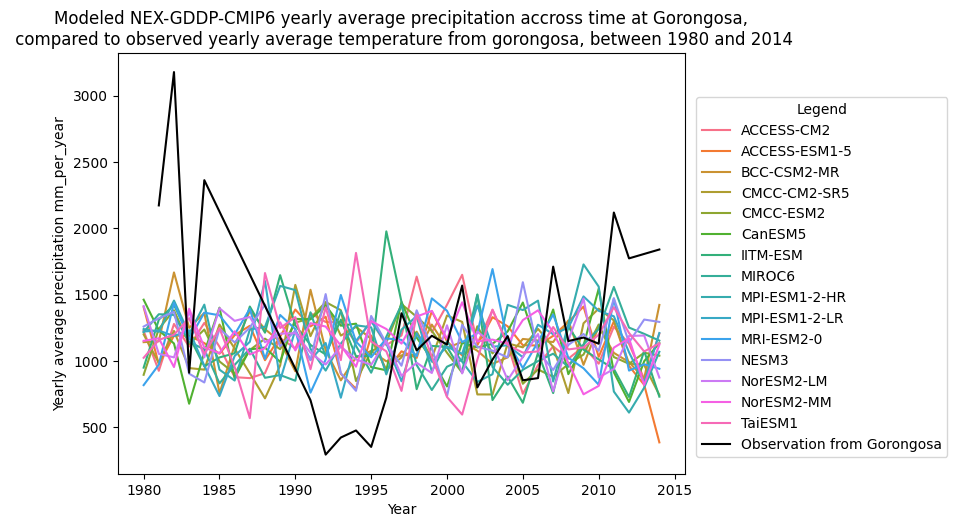

In [180]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

sns.lineplot(data=pr_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Mean of the daily precipitation rate mm_per_day']].mean()*365.25,x='Year', y='Mean of the daily precipitation rate mm_per_day',hue='Model',errorbar=tuple_error_bar,ax=ax)
sns.lineplot(data=pr_obs_gorongosa_from_gorongosa.groupby('Year')[['Mean of the daily precipitation rate mm_per_day']].mean()*365.25,x='Year', y='Mean of the daily precipitation rate mm_per_day',color='black',label='Observation from Gorongosa',errorbar=tuple_error_bar,ax=ax)

# display the legend
handles, labels=ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.38, 0.88),title='Legend')
ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
plt.ylabel('Yearly average precipitation mm_per_year')
plt.title('Modeled NEX-GDDP-CMIP6 yearly average precipitation accross time at Gorongosa,\n compared to observed yearly average temperature from gorongosa, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Comp_hist_m_o_pr.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [176]:
pr_historic_modeled_NEXGDDPCMIP6_gorongosa['Mean of the daily precipitation rate mm_per_year']=pr_historic_modeled_NEXGDDPCMIP6_gorongosa[['Mean of the daily precipitation rate mm_per_day']].values*365.25

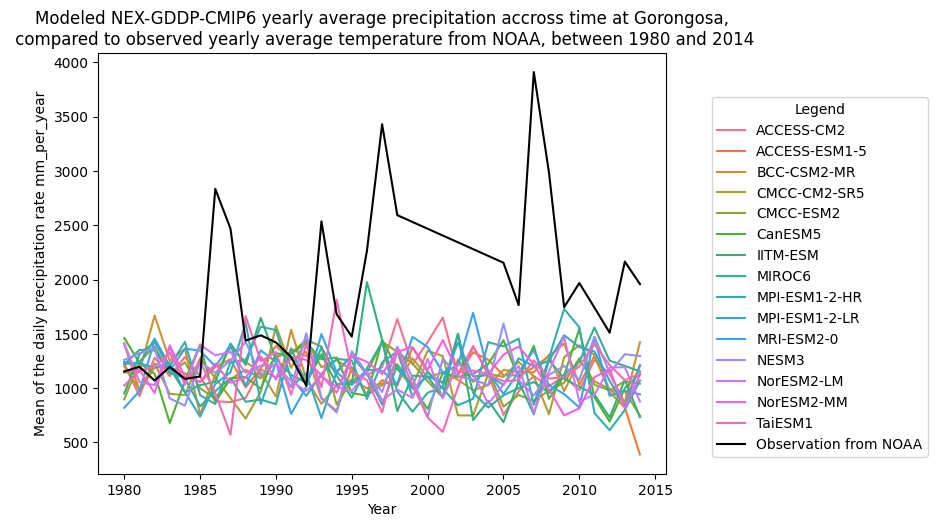

In [179]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

sns.lineplot(data=pr_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Mean of the daily precipitation rate mm_per_year']].mean(),x='Year', y='Mean of the daily precipitation rate mm_per_year',hue='Model',errorbar=tuple_error_bar,ax=ax)
data_line=daily_sum_obs_from_NOAA_gorongosa[daily_sum_obs_from_NOAA_gorongosa['Year'].between(1980,2014)]
data_line = data_line.groupby('Year')[['PRCP']].mean()*365.25
sns.lineplot(data=data_line,x='Year', y='PRCP',color='black',label='Observation from NOAA',errorbar=tuple_error_bar,ax=ax)

# display the legend
handles, labels=ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.38, 0.88),title='Legend')
ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
plt.title('Modeled NEX-GDDP-CMIP6 yearly average precipitation accross time at Gorongosa,\n compared to observed yearly average temperature from NOAA, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Comp_hist_m_o_pr.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [140]:
daily_sum_obs_from_NOAA

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-04-05,2.0,",,S",23.8,"H,,S",29.0,",D,S",20.0,",,S"
1,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-17,0.0,",,S",18.2,"H,,S",27.0,",,S",11.0,",,S"
2,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-23,NaN,NaN,21.0,"H,,S",NaN,NaN,NaN,NaN
3,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-02,0.0,",,S",21.5,"H,,S",NaN,NaN,16.0,",,S"
4,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-03,0.0,",,S",20.5,"H,,S",NaN,NaN,16.0,",,S"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161770,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-27,NaN,NaN,28.8,"H,,S",32.3,",,S",NaN,NaN
161771,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-28,NaN,NaN,29.4,"H,,S",NaN,NaN,25.0,",,S"
161772,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-29,NaN,NaN,29.6,"H,,S",NaN,NaN,26.0,",,S"
161773,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-30,24.9,",,S",28.3,"H,,S",31.2,",,S",25.7,",,S"


In [137]:
daily_sum_obs_from_NOAA

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-04-05,2.0,",,S",23.8,"H,,S",29.0,",D,S",20.0,",,S"
1,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-17,0.0,",,S",18.2,"H,,S",27.0,",,S",11.0,",,S"
2,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-06-23,NaN,NaN,21.0,"H,,S",NaN,NaN,NaN,NaN
3,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-02,0.0,",,S",21.5,"H,,S",NaN,NaN,16.0,",,S"
4,MZM00067223,"MONTEPUEZ, MZ",-13.133,39.033,535.0,1974-07-03,0.0,",,S",20.5,"H,,S",NaN,NaN,16.0,",,S"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161770,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-27,NaN,NaN,28.8,"H,,S",32.3,",,S",NaN,NaN
161771,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-28,NaN,NaN,29.4,"H,,S",NaN,NaN,25.0,",,S"
161772,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-29,NaN,NaN,29.6,"H,,S",NaN,NaN,26.0,",,S"
161773,MZ000067297,"BEIRA, MZ",-19.800,34.900,16.0,2020-12-30,24.9,",,S",28.3,"H,,S",31.2,",,S",25.7,",,S"


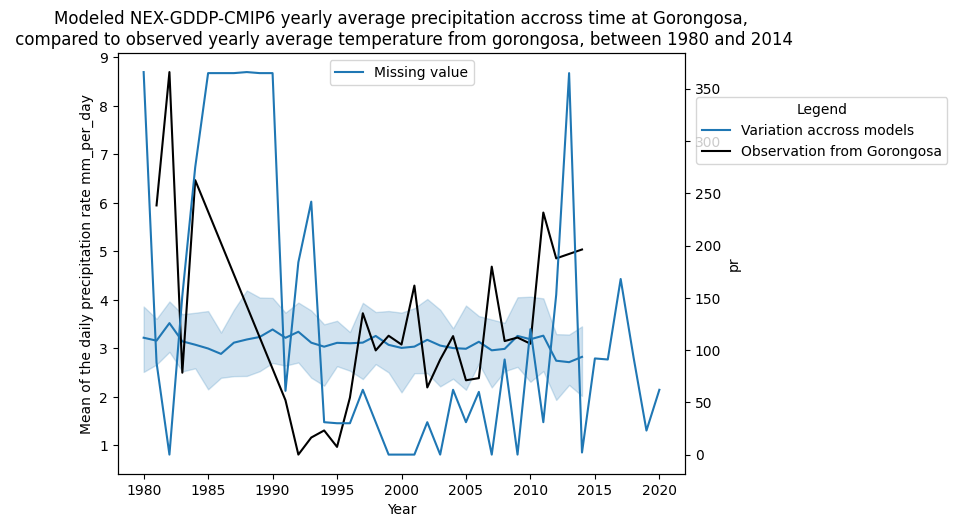

In [77]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

sns.lineplot(data=pr_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Mean of the daily precipitation rate mm_per_day']].mean(),x='Year', y='Mean of the daily precipitation rate mm_per_day',label='Variation accross models',errorbar=tuple_error_bar,ax=ax)
sns.lineplot(data=pr_obs_gorongosa_from_gorongosa.groupby('Year')[['Mean of the daily precipitation rate mm_per_day']].mean(),x='Year', y='Mean of the daily precipitation rate mm_per_day',color='black',label='Observation from Gorongosa',errorbar=tuple_error_bar,ax=ax)
ax2 = plt.twinx()
sns.lineplot(data=na_values_pr_obs_gorongosa_from_gorongosa,x='Year',y='pr',label='Missing value',ax=ax2)

# display the legend
handles, labels=ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.38, 0.88),title='Legend')
ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
plt.title('Modeled NEX-GDDP-CMIP6 yearly average precipitation accross time at Gorongosa,\n compared to observed yearly average temperature from gorongosa, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Comp_hist_m_o_pr2.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written
plt.show()

In [73]:
na_values_pr_obs_gorongosa_from_gorongosa

,Year,time,pr,Month,Season
0,1980,0,366,0,0
1,1981,0,88,0,0
2,1982,0,0,0,0
3,1983,0,152,0,0
4,1984,0,275,0,0
5,1985,0,365,0,0
6,1986,0,365,0,0
7,1987,0,365,0,0
8,1988,0,366,0,0
9,1989,0,365,0,0


<Axes: xlabel='Year', ylabel='pr'>

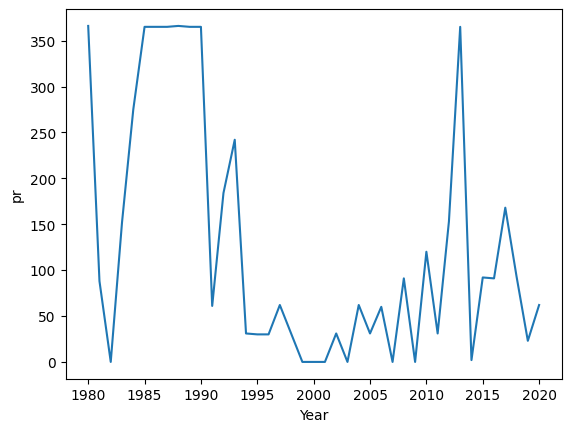

In [75]:
sns.lineplot(data=na_values_pr_obs_gorongosa_from_gorongosa,x='Year',y='pr')

In [78]:
pr_obs_gorongosa_from_gorongosa['Model']='Observation from Gorongosa'
pr_obs_gorongosa_from_gorongosa=pr_obs_gorongosa_from_gorongosa.rename(columns={'pr':'Mean of the daily precipitation rate mm_per_day'})
pr_obs_gorongosa_from_gorongosa

,time,Mean of the daily precipitation rate mm_per_day,Year,Month,Season,Model
0,1980-01-01,NaN,1980,Jan,Humid,Observation from Gorongosa
1,1980-01-02,NaN,1980,Jan,Humid,Observation from Gorongosa
2,1980-01-03,NaN,1980,Jan,Humid,Observation from Gorongosa
3,1980-01-04,NaN,1980,Jan,Humid,Observation from Gorongosa
4,1980-01-05,NaN,1980,Jan,Humid,Observation from Gorongosa
...,...,...,...,...,...,...
12779,2014-12-27,3.2,2014,Dec,Humid,Observation from Gorongosa
12780,2014-12-28,29.0,2014,Dec,Humid,Observation from Gorongosa
12781,2014-12-29,3.5,2014,Dec,Humid,Observation from Gorongosa
12782,2014-12-30,125.0,2014,Dec,Humid,Observation from Gorongosa


In [79]:
df_boxplot=pd.concat([pr_obs_gorongosa_from_gorongosa,pr_historic_modeled_NEXGDDPCMIP6_gorongosa])
df_boxplot

,time,Mean of the daily precipitation rate mm_per_day,Year,Month,Season,Model,Name project,Experiment,Latitude,Longitude,Date
0,1980-01-01,NaN,1980,Jan,Humid,Observation from Gorongosa,NaN,NaN,NaN,NaN,NaN
1,1980-01-02,NaN,1980,Jan,Humid,Observation from Gorongosa,NaN,NaN,NaN,NaN,NaN
2,1980-01-03,NaN,1980,Jan,Humid,Observation from Gorongosa,NaN,NaN,NaN,NaN,NaN
3,1980-01-04,NaN,1980,Jan,Humid,Observation from Gorongosa,NaN,NaN,NaN,NaN,NaN
4,1980-01-05,NaN,1980,Jan,Humid,Observation from Gorongosa,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2596885,NaN,15.047861,2014,Dec,Humid,TaiESM1,Gorongosa_EIB,historical,-18.625,34.125,27-12-2014
2596886,NaN,21.683533,2014,Dec,Humid,TaiESM1,Gorongosa_EIB,historical,-18.625,34.125,28-12-2014
2596887,NaN,8.551384,2014,Dec,Humid,TaiESM1,Gorongosa_EIB,historical,-18.625,34.125,29-12-2014
2596888,NaN,2.862741,2014,Dec,Humid,TaiESM1,Gorongosa_EIB,historical,-18.625,34.125,30-12-2014


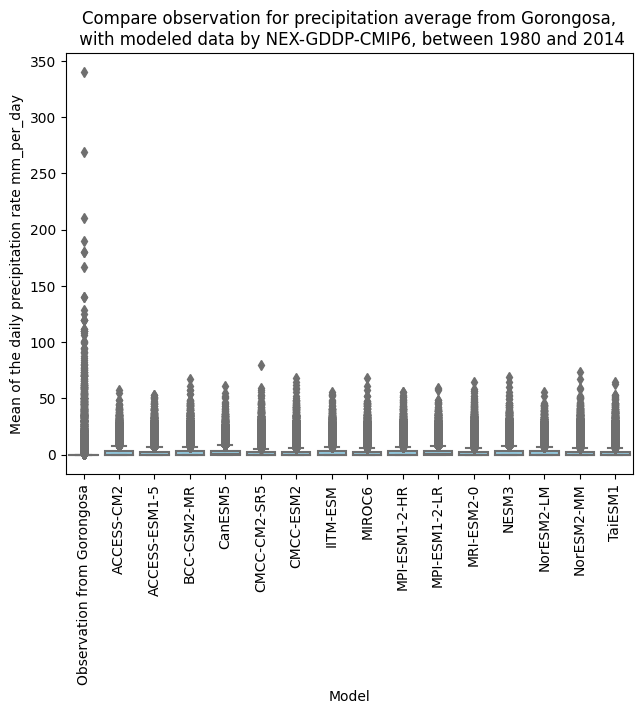

In [80]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

cols = ['pink' if (x =='Observation from Gorongosa') else 'skyblue' for x in df_boxplot.Model.drop_duplicates().values]
sns.boxplot(data=df_boxplot,x=df_boxplot.Model, y='Mean of the daily precipitation rate mm_per_day',palette=cols,ax=ax)

# display the legend
#handles, labels=ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.3, 1),title='Legend')
#ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Compare observation for precipitation average from Gorongosa,\n with modeled data by NEX-GDDP-CMIP6, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\BoxplotsComp_hist_m_o_pr.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written

plt.show()

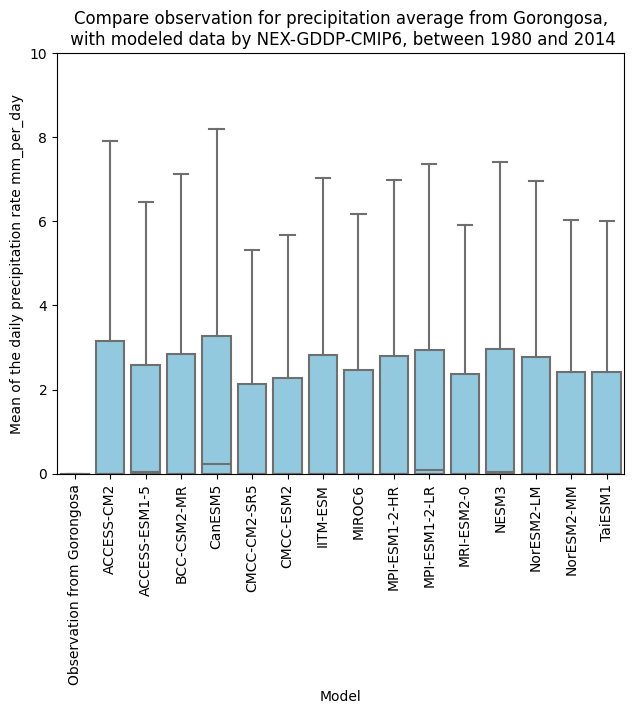

In [81]:
# without outliers

fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

cols = ['pink' if (x =='Observation from Gorongosa') else 'skyblue' for x in df_boxplot.Model.drop_duplicates().values]
sns.boxplot(data=df_boxplot,x=df_boxplot.Model, y='Mean of the daily precipitation rate mm_per_day', fliersize=0,palette=cols,ax=ax)

# display the legend
#handles, labels=ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.3, 1),title='Legend')
#ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylim((0,10))
plt.title('Compare observation for precipitation average from Gorongosa,\n with modeled data by NEX-GDDP-CMIP6, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Boxplots_without_outliers_Comp_hist_m_o_pr.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written

plt.show()

## Temperature

In [82]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa=tas_historic_modeled_NEXGDDPCMIP6[tas_historic_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB'].drop('Name project',axis=1)
tas_historic_modeled_NEXGDDPCMIP6_gorongosa=add_year_month_season(tas_historic_modeled_NEXGDDPCMIP6_gorongosa,'Date')
tas_historic_modeled_NEXGDDPCMIP6_gorongosa = tas_historic_modeled_NEXGDDPCMIP6_gorongosa[tas_historic_modeled_NEXGDDPCMIP6_gorongosa['Year'].between(start_year_hist,stop_year_hist)]

In [83]:
daily_sum_obs_from_NOAA_gorongosa = daily_sum_obs_from_NOAA_gorongosa[daily_sum_obs_from_NOAA_gorongosa['Year'].between(start_year_hist,stop_year_hist)]

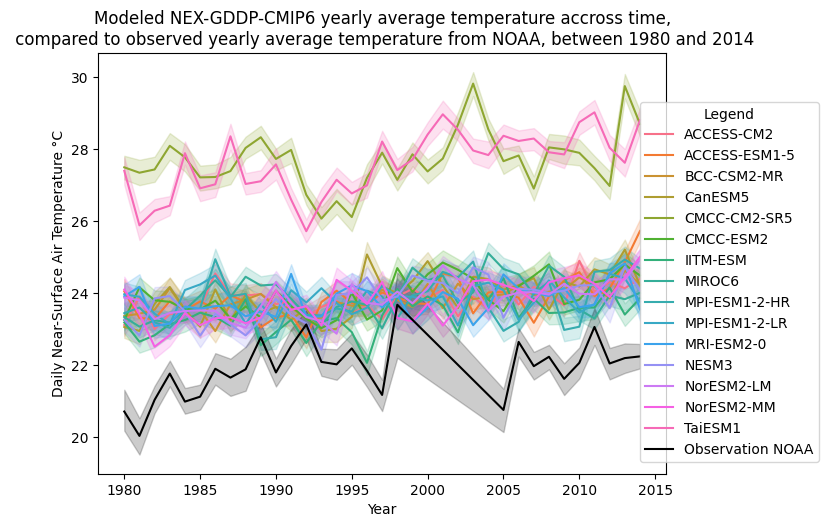

In [84]:
# with confidence interval of 95 %
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.

sns.lineplot(data=tas_historic_modeled_NEXGDDPCMIP6_gorongosa,x='Year', y='Daily Near-Surface Air Temperature °C',hue='Model',ax=ax)
sns.lineplot(data=daily_sum_obs_from_NOAA_gorongosa,x='Year', y='TAVG',color='black',label='Observation NOAA',ax=ax)

# display the legend
handles, labels=ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.21, 0.87),title='Legend')
ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
plt.title('Modeled NEX-GDDP-CMIP6 yearly average temperature accross time,\n compared to observed yearly average temperature from NOAA, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Graphs_ci95_Comp_hist_m_o_tas.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written


plt.show()

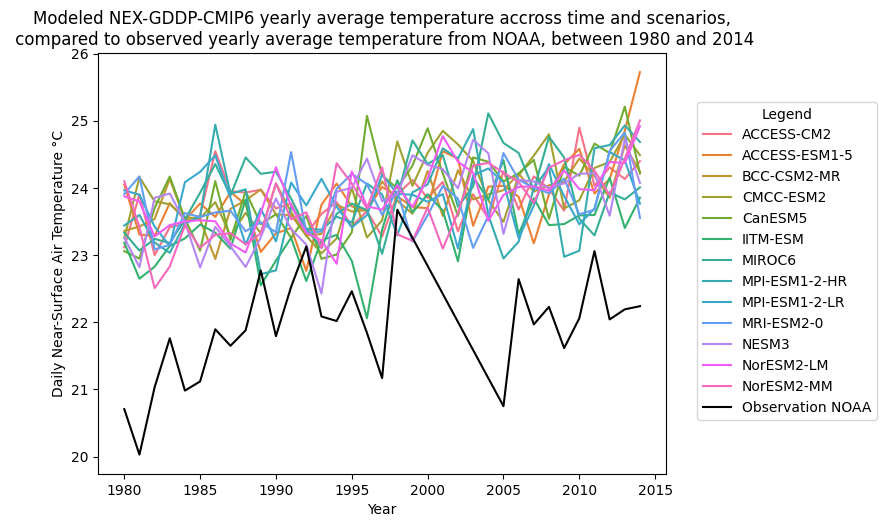

In [135]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.
data1 = tas_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Daily Near-Surface Air Temperature °C']].mean().reset_index()
sns.lineplot(data=data1,x='Year', y='Daily Near-Surface Air Temperature °C',hue='Model',errorbar=tuple_error_bar,ax=ax)
sns.lineplot(data=daily_sum_obs_from_NOAA_gorongosa[['Year','TAVG']].groupby('Year')[['TAVG']].mean(),x='Year', y='TAVG',color='black',label='Observation NOAA',errorbar=tuple_error_bar,ax=ax)

# display the legend
handles, labels=ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.3, 0.87),title='Legend')
ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
plt.title('Modeled NEX-GDDP-CMIP6 yearly average temperature accross time and scenarios,\n compared to observed yearly average temperature from NOAA, between '+str(start_year_hist)+' and '+str(stop_year_hist))
path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Graphs_pi80_Comp_hist_m_o_tas.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written


plt.show()

In [133]:
daily_sum_obs_from_NOAA_gorongosa

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season
6665,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-01,0.0,",,Q",24.3,"H,,S",29.5,",,Q",20.2,",,Q",1980,Jan,Humid
6666,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-02,0.0,",,Q",24.3,"H,,S",32.4,",,Q",20.2,",,Q",1980,Jan,Humid
6667,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-03,0.0,",,Q",25.8,"H,,S",31.7,",,Q",20.7,",,Q",1980,Jan,Humid
6668,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-04,0.0,",,Q",25.8,"H,,S",33.5,",,Q",21.0,",,Q",1980,Jan,Humid
6669,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-05,0.0,",,Q",26.8,"H,,S",34.0,",,Q",22.3,",,Q",1980,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14489,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-27,NaN,NaN,24.9,"H,,S",NaN,NaN,21.8,",,S",2014,Dec,Humid
14490,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-28,NaN,NaN,25.9,"H,,S",29.2,",,S",20.0,",,S",2014,Dec,Humid
14491,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-29,23.1,",,S",24.3,"H,,S",30.0,",,S",20.9,",,S",2014,Dec,Humid
14492,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-30,45.0,",,S",22.9,"H,,S",25.3,",,S",21.0,",,S",2014,Dec,Humid


In [130]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa.groupby(['Experiment','Model','Year'])[['Daily Near-Surface Air Temperature °C']].mean().reset_index()

,Experiment,Model,Year,Daily Near-Surface Air Temperature °C
0,historical,ACCESS-CM2,1980,23.116571
1,historical,ACCESS-CM2,1981,23.903633
2,historical,ACCESS-CM2,1982,22.999906
3,historical,ACCESS-CM2,1983,23.414344
4,historical,ACCESS-CM2,1984,23.465320
...,...,...,...,...
450,historical,NorESM2-MM,2010,24.492781
451,historical,NorESM2-MM,2011,24.259290
452,historical,NorESM2-MM,2012,23.892582
453,historical,NorESM2-MM,2013,24.436982


In [131]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa.Model.unique()

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5',
       'CMCC-ESM2', 'IITM-ESM', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM'],
      dtype=object)

In [86]:
daily_sum_obs_from_NOAA_gorongosa['Model']='Observation NOAA'
daily_sum_obs_from_NOAA_gorongosa=daily_sum_obs_from_NOAA_gorongosa.rename(columns={'TAVG':'Daily Near-Surface Air Temperature °C'})
daily_sum_obs_from_NOAA_gorongosa

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\1296435330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_sum_obs_from_NOAA_gorongosa['Model']='Observation NOAA'


,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,Daily Near-Surface Air Temperature °C,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,Year,Month,Season,Model
6665,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-01,0.0,",,Q",24.3,"H,,S",29.5,",,Q",20.2,",,Q",1980,Jan,Humid,Observation NOAA
6666,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-02,0.0,",,Q",24.3,"H,,S",32.4,",,Q",20.2,",,Q",1980,Jan,Humid,Observation NOAA
6667,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-03,0.0,",,Q",25.8,"H,,S",31.7,",,Q",20.7,",,Q",1980,Jan,Humid,Observation NOAA
6668,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-04,0.0,",,Q",25.8,"H,,S",33.5,",,Q",21.0,",,Q",1980,Jan,Humid,Observation NOAA
6669,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-05,0.0,",,Q",26.8,"H,,S",34.0,",,Q",22.3,",,Q",1980,Jan,Humid,Observation NOAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14489,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-27,NaN,NaN,24.9,"H,,S",NaN,NaN,21.8,",,S",2014,Dec,Humid,Observation NOAA
14490,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-28,NaN,NaN,25.9,"H,,S",29.2,",,S",20.0,",,S",2014,Dec,Humid,Observation NOAA
14491,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-29,23.1,",,S",24.3,"H,,S",30.0,",,S",20.9,",,S",2014,Dec,Humid,Observation NOAA
14492,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,2014-12-30,45.0,",,S",22.9,"H,,S",25.3,",,S",21.0,",,S",2014,Dec,Humid,Observation NOAA


In [87]:
df_boxplot=pd.concat([daily_sum_obs_from_NOAA_gorongosa,tas_historic_modeled_NEXGDDPCMIP6_gorongosa])
df_boxplot

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,Daily Near-Surface Air Temperature °C,TAVG_ATTRIBUTES,...,TMIN,TMIN_ATTRIBUTES,Year,Month,Season,Model,Experiment,Latitude,Longitude,Date
6665,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-01,0.0,",,Q",24.300000,"H,,S",...,20.2,",,Q",1980,Jan,Humid,Observation NOAA,NaN,NaN,NaN,NaN
6666,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-02,0.0,",,Q",24.300000,"H,,S",...,20.2,",,Q",1980,Jan,Humid,Observation NOAA,NaN,NaN,NaN,NaN
6667,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-03,0.0,",,Q",25.800000,"H,,S",...,20.7,",,Q",1980,Jan,Humid,Observation NOAA,NaN,NaN,NaN,NaN
6668,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-04,0.0,",,Q",25.800000,"H,,S",...,21.0,",,Q",1980,Jan,Humid,Observation NOAA,NaN,NaN,NaN,NaN
6669,MZ000067295,"CHIMOIO, MZ",-19.117,33.467,732.0,1980-01-05,0.0,",,Q",26.800000,"H,,S",...,22.3,",,Q",1980,Jan,Humid,Observation NOAA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.821167,NaN,...,NaN,NaN,2014,Dec,Humid,TaiESM1,historical,-18.625,34.125,27-12-2014
2596886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.735199,NaN,...,NaN,NaN,2014,Dec,Humid,TaiESM1,historical,-18.625,34.125,28-12-2014
2596887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.086426,NaN,...,NaN,NaN,2014,Dec,Humid,TaiESM1,historical,-18.625,34.125,29-12-2014
2596888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.556610,NaN,...,NaN,NaN,2014,Dec,Humid,TaiESM1,historical,-18.625,34.125,30-12-2014


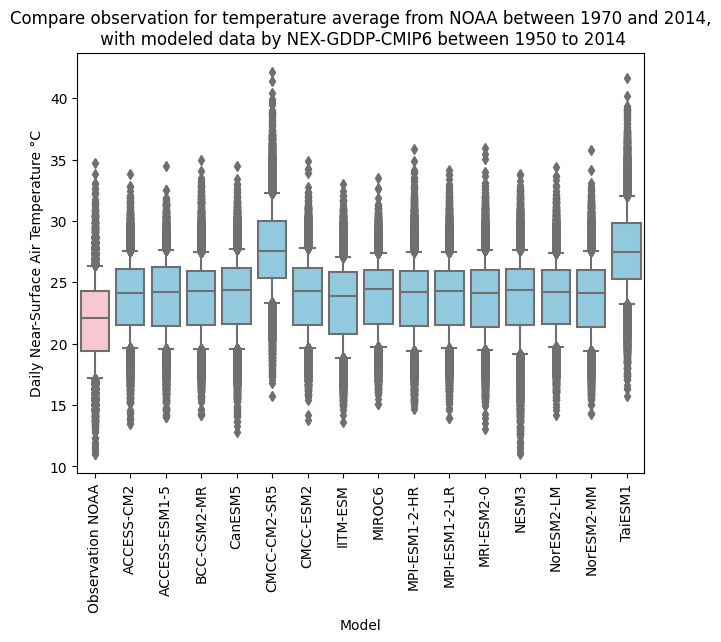

In [88]:
fig,ax=plt.subplots()
plt.tight_layout() # Adjust the padding between and around subplots.
cols = ['pink' if (x =='Observation NOAA') else 'skyblue' for x in df_boxplot.Model.drop_duplicates().values]
sns.boxplot(data=df_boxplot,x=df_boxplot.Model, y='Daily Near-Surface Air Temperature °C',palette=cols,whis=[10,90],ax=ax)

# display the legend
#handles, labels=ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.3, 1),title='Legend')
#ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Compare observation for temperature average from NOAA between 1970 and 2014,\n with modeled data by NEX-GDDP-CMIP6 between 1950 to 2014')

path_figure=r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures\Boxplots_whis10_90_Comp_hist_m_o_tas.png'
plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written

plt.show()

We can see that 'CMCC-CM2-SR5' and 'TaiESM1' do not have the same behaviour as the other models. We will take them off for the following analysis of the temperature

In [89]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa

,Experiment,Model,Latitude,Longitude,Date,Daily Near-Surface Air Temperature °C,Year,Month,Season
2251732,historical,ACCESS-CM2,-18.625,34.125,01-01-1980,22.476044,1980,Jan,Humid
2251733,historical,ACCESS-CM2,-18.625,34.125,02-01-1980,24.005035,1980,Jan,Humid
2251734,historical,ACCESS-CM2,-18.625,34.125,03-01-1980,25.282990,1980,Jan,Humid
2251735,historical,ACCESS-CM2,-18.625,34.125,04-01-1980,24.437012,1980,Jan,Humid
2251736,historical,ACCESS-CM2,-18.625,34.125,05-01-1980,23.955902,1980,Jan,Humid
...,...,...,...,...,...,...,...,...,...
2596885,historical,TaiESM1,-18.625,34.125,27-12-2014,32.821167,2014,Dec,Humid
2596886,historical,TaiESM1,-18.625,34.125,28-12-2014,33.735199,2014,Dec,Humid
2596887,historical,TaiESM1,-18.625,34.125,29-12-2014,34.086426,2014,Dec,Humid
2596888,historical,TaiESM1,-18.625,34.125,30-12-2014,34.556610,2014,Dec,Humid


In [90]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa=tas_historic_modeled_NEXGDDPCMIP6_gorongosa[tas_historic_modeled_NEXGDDPCMIP6_gorongosa['Model']!='TaiESM1']

In [91]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa=tas_historic_modeled_NEXGDDPCMIP6_gorongosa[tas_historic_modeled_NEXGDDPCMIP6_gorongosa['Model']!='CMCC-CM2-SR5']

In [92]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa

,Experiment,Model,Latitude,Longitude,Date,Daily Near-Surface Air Temperature °C,Year,Month,Season
2251732,historical,ACCESS-CM2,-18.625,34.125,01-01-1980,22.476044,1980,Jan,Humid
2251733,historical,ACCESS-CM2,-18.625,34.125,02-01-1980,24.005035,1980,Jan,Humid
2251734,historical,ACCESS-CM2,-18.625,34.125,03-01-1980,25.282990,1980,Jan,Humid
2251735,historical,ACCESS-CM2,-18.625,34.125,04-01-1980,24.437012,1980,Jan,Humid
2251736,historical,ACCESS-CM2,-18.625,34.125,05-01-1980,23.955902,1980,Jan,Humid
...,...,...,...,...,...,...,...,...,...
2573144,historical,NorESM2-MM,-18.625,34.125,27-12-2014,30.512054,2014,Dec,Humid
2573145,historical,NorESM2-MM,-18.625,34.125,28-12-2014,31.226105,2014,Dec,Humid
2573146,historical,NorESM2-MM,-18.625,34.125,29-12-2014,30.568115,2014,Dec,Humid
2573147,historical,NorESM2-MM,-18.625,34.125,30-12-2014,29.807404,2014,Dec,Humid


# Create overview of trends (monthly, annual evolution)

In [167]:
# data_1 : first set of data to be used, should only contains the location of interest
# source_1 : source of the first set of data
# data_2 : second set of dat to be used, should only contains the location of interest
# source_2 : source of the second set of data

def trends_month(climate_var,data_1,source_1,data_2,source_2,stats,location,temporal_resolution='Month',start_year_line=1970,stop_year_line=2014,start_year_boxplot=2015,stop_year_boxplot=2100):
    
    (climate_var_longName,unit)= infos_str(climate_var,temporal_resolution)
    
    # define the new common name, that will be used as y_axis for boxplots and line
    new_name_col = temporal_resolution+'ly '+climate_var_longName+' '+unit
    
    if 'NEX-GDDP-CMIP6' in source_1:
        if (start_year_boxplot!=2014) or (stop_year_boxplot!=2100):
            data_1=data_1[data_1['Year'].between(start_year_boxplot,stop_year_boxplot)]
        data_boxplot=prepare_NEX_GDDP_CMIP6(data_1,climate_var_longName,stats,temporal_resolution,new_name_col)
        source_boxplot=source_1
    if 'NEX-GDDP-CMIP6' in source_2:
        if (start_year_boxplot!=2014) or (stop_year_boxplot!=2100):
            data_2=data_2[data_2['Year'].between(start_year_boxplot,stop_year_boxplot)]
        data_boxplot=prepare_NEX_GDDP_CMIP6(data_2,climate_var_longName,stats,temporal_resolution,new_name_col)
        source_boxplot=source_2
    if 'NOAA' in source_1:
        if (start_year_line!=1970) or (stop_year_line!=2014):
            data_1=data_1[data_1['Year'].between(start_year_line,stop_year_line)]
        title_column=title_column_NOAA_obs(source_1,climate_var)
        data_line=prepare_NOAA(data_1,title_column,temporal_resolution,new_name_col)
        source_line=source_1
    if 'NOAA' in source_2:
        if (start_year_line!=1970) or (stop_year_line!=2014):
            data_2=data_2[data_2['Year'].between(start_year_line,stop_year_line)]
        title_column=title_column_NOAA_obs(source_2,climate_var)
        data_line=prepare_NOAA(data_2,title_column,temporal_resolution,new_name_col)
        source_line=source_2
    
    if temporal_resolution == 'Month': # to plot the data in the chronological order of the months
        month_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        data_boxplot=data_boxplot.reset_index().set_index(temporal_resolution).loc[month_order].reset_index()
        data_line=data_line.reset_index().set_index(temporal_resolution).loc[month_order].reset_index()    
    
    if stats == 'Sum':
        title_plot = climate_var_longName+' '+unit+', modeled by '+source_boxplot+',\nbetween '+str(start_year_boxplot)+' and '+str(stop_year_boxplot)+' at '+location+' compared with '+source_line+'\nobservation data, between '+str(start_year_line)+' and '+str(stop_year_line)
    else:
        title_plot = stats+' '+climate_var_longName+' '+unit+', modeled by '+source_boxplot+',\nbetween '+str(start_year_boxplot)+' and '+str(stop_year_boxplot)+' at '+location+' compared with '+source_line+'\nobservation data, between '+str(start_year_line)+' and '+str(stop_year_line)
        
    boxplots_line(data_boxplot,data_line,temporal_resolution,new_name_col,source_line,title_plot)

In [168]:
# select years because impossible to read
def trends_year(climate_var,data_1,source_1,stats,location,start_year,stop_year,temporal_resolution='Year'):
    (climate_var_longName,unit)= infos_str(climate_var,temporal_resolution)
    
    # define the new common name, that will be used as y_axis for boxplots and line
    new_name_col = temporal_resolution+'ly '+climate_var_longName+' '+unit
    
    data_boxplot=prepare_NEX_GDDP_CMIP6(data_1,climate_var_longName,stats,temporal_resolution,new_name_col)
    if stats =='Sum':
        stats = ''
    
    if (stop_year-start_year+1)>10:
        for i in np.arange(0,round(((stop_year-start_year+1)/10))):
            df_filter=data_boxplot[data_boxplot['Year'].between(start_year+i*10,start_year+i*10+10)]
            title_plot = stats+' '+ climate_var_longName+' '+unit+' between '+str(start_year)+' and '+str(stop_year)+' at '+location
            boxplots(df_filter,temporal_resolution,new_name_col,title_plot)
    else:
        df_filter=data_boxplot[data_boxplot['Year'].between(start_year,stop_year)]
        title_plot = stats+' '+climate_var_longName+' '+unit+' between '+str(start_year)+' and '+str(stop_year)+' at '+location
        boxplots(df_filter,temporal_resolution,new_name_col,title_plot)

In [169]:
def prepare_NEX_GDDP_CMIP6(df,climate_var_longName,stats,temporal_resolution,new_name_col):
    try:
        try:
            title_column=df.filter(like=climate_var_longName, axis=1).columns[0]
        except:
            title_column=df.filter(like=climate_var_longName.capitalize(), axis=1).columns[0]
    except:
        title_column=df.filter(like=climate_var_longName.upper(), axis=1).columns[0]
        
    if stats == 'Average':
        data_NEXGDDPCMIP6=df[['Experiment','Model',temporal_resolution,title_column]].groupby(['Experiment','Model',temporal_resolution]).mean().rename(columns={title_column:new_name_col}).reset_index()
    if stats == 'Sum':
        data_NEXGDDPCMIP6=df[['Experiment','Model',temporal_resolution,title_column]].groupby(['Experiment','Model',temporal_resolution]).sum().rename(columns={title_column:new_name_col}).reset_index()
    if stats == 'Median':
        data_NEXGDDPCMIP6=df[['Experiment','Model',temporal_resolution,title_column]].groupby(['Experiment','Model',temporal_resolution]).median().rename(columns={title_column:new_name_col}).reset_index()
    
    if 'pr' in climate_var_longName and temporal_resolution =='Month':
        data_NEXGDDPCMIP6[new_name_col] = data_NEXGDDPCMIP6[[new_name_col]].values*30
    
    return data_NEXGDDPCMIP6

In [174]:
def prepare_NOAA(df_NOAA,title_column,temporal_resolution,new_name_col):
    df_NOAA = df_NOAA.reset_index()
    df = df_NOAA[[title_column,temporal_resolution]].groupby(temporal_resolution).mean().rename(columns={title_column:new_name_col}).reset_index()
    
    print('title_column '+title_column)
    print('temporal_resolution '+temporal_resolution)
    
    
    if 'PR' in title_column and temporal_resolution=='Month':
        print('pr and month, multiplication by 30')
        df[new_name_col] = df[[new_name_col]].values*30
    
    return df

In [126]:
def infos_str(climate_var,temporal_resolution):
    if climate_var=='pr':
        climate_var_longName = 'precipitation'
        unit='mm/'+temporal_resolution[0].lower()+temporal_resolution[1:len(temporal_resolution)]
    if 'tas' in climate_var:
        unit=u'\N{DEGREE SIGN}C'
        climate_var_longName = 'temperature'
    if climate_var=='tasmax':
        climate_var_longName = 'Daily Maximum Near-Surface Air Temperature '
    if climate_var=='tasmin':
        climate_var_longName = 'minimum '+climate_var_longName
    return climate_var_longName,unit

In [98]:
def title_column_NOAA_obs(source,climate_var):
    if source == 'NOAA':
        if climate_var=='pr':
            title_column='PRCP'
        if climate_var=='tas':
            title_column='TAVG'
        if climate_var=='tasmax':
            title_column='TMAX'
        if climate_var=='tasmin':
            title_column='TMIN'
        return title_column

In [99]:
# data_boxplot : dataframr that will be used to do the boxplots
# data_line : dataframe that will be used to add a line
# x_axis : Name of the column that wil be used for the x_axis
# y_axis : Name of the column that wil be used for the y_axis
# ----> x_axis and y_axis are both a str, and both should be used as name of colum in the dataframes for the boxplots and 
#       the line
# source_line : name of the source of the data plot in the line
# title_plot : title for this plot. Should be defined in the function before
# categories : default parameters, will be used for the hue of the boxplot. The hue is a third dimension along a depth axis, 
#              where different levels are plotted with different colors

#stats+' monthly precipitation mm/month between '+start_year+' and '+stop_year+'\n with '+source_obs+' observed data and '+source_model+' modeled data, at '+location

def boxplots_line(data_boxplot,data_line,x_axis,y_axis,source_line,title_plot,categories='Experiment'):
    fig,ax=plt.subplots()
    sns.boxplot(data=data_boxplot, x=x_axis, y=y_axis, hue=categories,ax=ax)
    ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
    sns.lineplot(data=data_line,x=x_axis, y=y_axis,ax=ax,label=source_line)
    
    # display the common legend for the line and boxplots
    handles, labels=ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.2, 0.5),title='Legend')
    ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
    plt.title(title_plot)
    path_figure=os.path.join(r'C:\Users\CLMRX\OneDrive - COWI\Documents\GitHub\CRVA_tool\outputs\figures','trend_month.png')
    plt.savefig(path_figure,format ='png') # savefig or save text must be before plt.show. for savefig, format should be explicity written

    plt.show()
    
# data_boxplot : dataframr that will be used to do the boxplots
# x_axis : Name of the column that wil be used for the x_axis
# y_axis : Name of the column that wil be used for the y_axis
# ----> x_axis and y_axis are both a str
# title_plot : title for this plot. Should be defined in the function before
# categories : default parameters, will be used for the hue of the boxplot. The hue is a third dimension along a depth axis, 
#              where different levels are plotted with different colors

#stats+' monthly precipitation mm/month between '+start_year+' and '+stop_year+'\n with '+source_obs+' observed data and '+source_model+' modeled data, at '+location

def boxplots(data_boxplot,x_axis,y_axis,title_plot,categories='Experiment'):
    fig,ax=plt.subplots()
    plt.tight_layout() # Adjust the padding between and around subplots.
    sns.boxplot(data=data_boxplot, x=x_axis, y=y_axis, hue=categories,whis=[10,90],ax=ax)
    
    # display the legend
    handles, labels=ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.1, 0.5),title='Legend')
    ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
    plt.title(title_plot)
    plt.show()

In [100]:
def plot_spaghetti(data,x_axis,y_axis,title_plot,have_legend):
    fig,ax=plt.subplots()
    sns.lineplot(data=data,x=x_axis, y=y_axis,ax=ax)
        # display the legend
    if have_legend == 'yes':
        handles, labels=ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.1, 0.5),title='Legend')
    #ax.get_legend().remove() # this line permits to have a common legend for the boxplots and the line
    plt.title(title_plot)
    plt.show()

In [101]:
path = r'C:\Users\CLMRX\COWI\A248363 - Climate analysis - Documents\General\CRVA_tool\Master_thesis\Project\3 - Implementation\1 - Data\1-BC\NOAA-ClimateDataOnline\3370204.csv'
daily_sum_obs_from_NOAA = pd.read_csv(path)
daily_sum_obs_from_NOAA_gorongosa = daily_sum_obs_from_NOAA[daily_sum_obs_from_NOAA['NAME']=='CHIMOIO, MZ']
daily_sum_obs_from_NOAA_gorongosa = add_year_month_season(daily_sum_obs_from_NOAA_gorongosa,'DATE')
daily_sum_obs_from_NOAA_gorongosa = daily_sum_obs_from_NOAA_gorongosa[daily_sum_obs_from_NOAA_gorongosa['Year'].between(start_year_hist,stop_year_hist)]

C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = Year
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = Month
C:\Users\CLMRX\AppData\Local\Temp\1\ipykernel_27848\2835294180.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [145]:
pr_modeled_NEXGDDPCMIP6_gorongosa

,Name project,Experiment,Model,Latitude,Longitude,Date,Mean of the daily precipitation rate mm_per_day,Year,Month,Season
2240775,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,01-01-1950,3.830031,1950,Jan,Humid
2240776,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,02-01-1950,2.447746,1950,Jan,Humid
2240777,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,03-01-1950,1.033146,1950,Jan,Humid
2240778,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,04-01-1950,12.821172,1950,Jan,Humid
2240779,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,05-01-1950,19.139076,1950,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...
4481545,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,27-12-2100,23.041087,2100,Dec,Humid
4481546,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,28-12-2100,16.827069,2100,Dec,Humid
4481547,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,29-12-2100,11.197097,2100,Dec,Humid
4481548,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,30-12-2100,20.220607,2100,Dec,Humid


title_column PRCP
temporal_resolution Month
pr and month, multiplication by 30


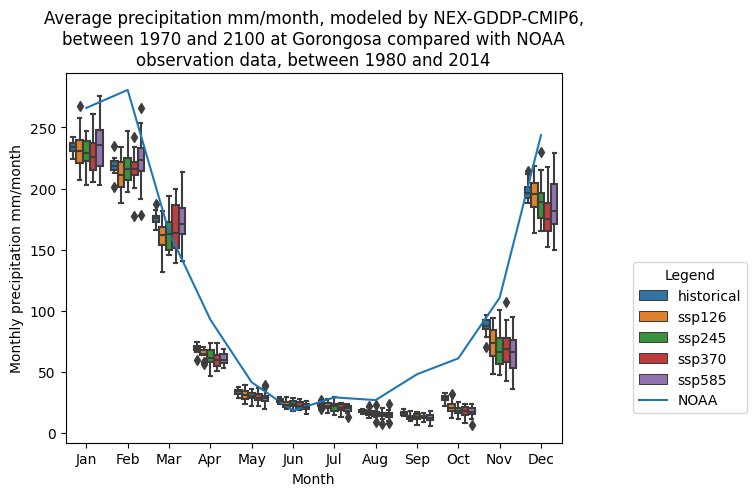

In [175]:
trends_month('pr',pr_modeled_NEXGDDPCMIP6_gorongosa,'NEX-GDDP-CMIP6',daily_sum_obs_from_NOAA_gorongosa,'NOAA','Average','Gorongosa',start_year_line=start_year_hist,stop_year_line=stop_year_hist,start_year_boxplot=1970,stop_year_boxplot=2100)

In [159]:
df['New col'] = df[['Monthly precipitation mm/month']].values*30
df

,Experiment,Model,Month,Monthly precipitation mm/month,New col
0,historical,ACCESS-CM2,Apr,2.403846,72.115386
1,historical,ACCESS-CM2,Aug,0.629578,18.887333
2,historical,ACCESS-CM2,Dec,7.074353,212.230577
3,historical,ACCESS-CM2,Feb,7.293395,218.801852
4,historical,ACCESS-CM2,Jan,7.904456,237.133677
...,...,...,...,...,...
895,ssp585,TaiESM1,Mar,6.228207,186.846208
896,ssp585,TaiESM1,May,1.271790,38.153704
897,ssp585,TaiESM1,Nov,2.094624,62.838721
898,ssp585,TaiESM1,Oct,0.699126,20.973783


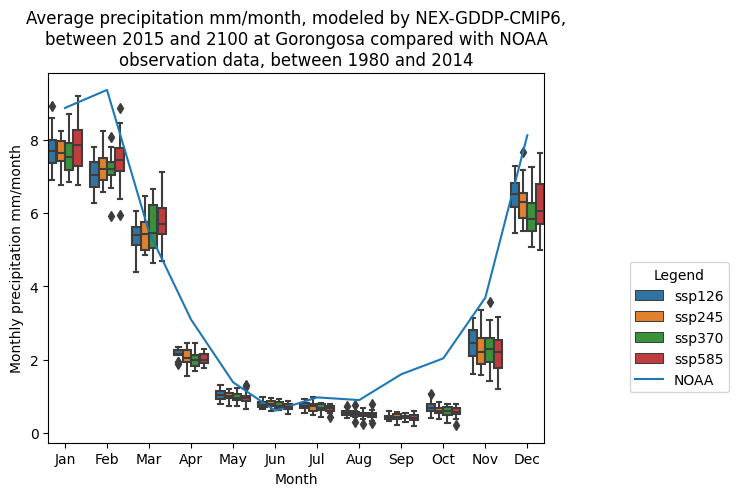

In [113]:
trends_month('pr',pr_modeled_NEXGDDPCMIP6_gorongosa,'NEX-GDDP-CMIP6',daily_sum_obs_from_NOAA_gorongosa,'NOAA','Average','Gorongosa',start_year_line=start_year_hist,stop_year_line=stop_year_hist)

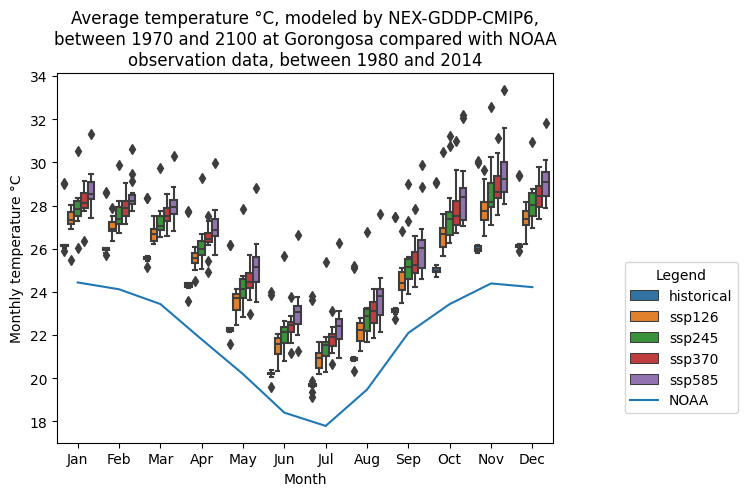

In [120]:
trends_month('tas',tas_modeled_NEXGDDPCMIP6_gorongosa,'NEX-GDDP-CMIP6',daily_sum_obs_from_NOAA_gorongosa,'NOAA','Average','Gorongosa',start_year_line=start_year_hist,stop_year_line=stop_year_hist,start_year_boxplot=1970,stop_year_boxplot=2100)

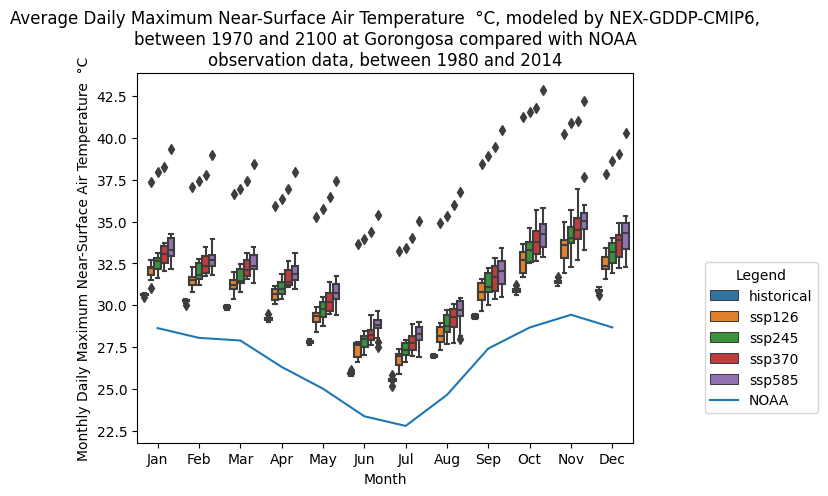

In [127]:
trends_month('tasmax',tasmax_modeled_NEXGDDPCMIP6_gorongosa,'NEX-GDDP-CMIP6',daily_sum_obs_from_NOAA_gorongosa,'NOAA','Average','Gorongosa',start_year_line=start_year_hist,stop_year_line=stop_year_hist,start_year_boxplot=1970,stop_year_boxplot=2100)

In [123]:
tasmax_modeled_NEXGDDPCMIP6_gorongosa

,Name project,Experiment,Model,Latitude,Longitude,Date,Daily Maximum Near-Surface Air Temperature °C,Year,Month,Season
2091390,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,01-01-1950,35.269379,1950,Jan,Humid
2091391,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,02-01-1950,35.528870,1950,Jan,Humid
2091392,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,03-01-1950,35.527130,1950,Jan,Humid
2091393,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,04-01-1950,36.416931,1950,Jan,Humid
2091394,Gorongosa_EIB,historical,ACCESS-CM2,-18.625,34.125,05-01-1950,30.323273,1950,Jan,Humid
...,...,...,...,...,...,...,...,...,...,...
4182775,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,27-12-2100,34.998383,2100,Dec,Humid
4182776,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,28-12-2100,42.575562,2100,Dec,Humid
4182777,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,29-12-2100,43.275574,2100,Dec,Humid
4182778,Gorongosa_EIB,ssp370,TaiESM1,-18.625,34.125,30-12-2100,30.833649,2100,Dec,Humid


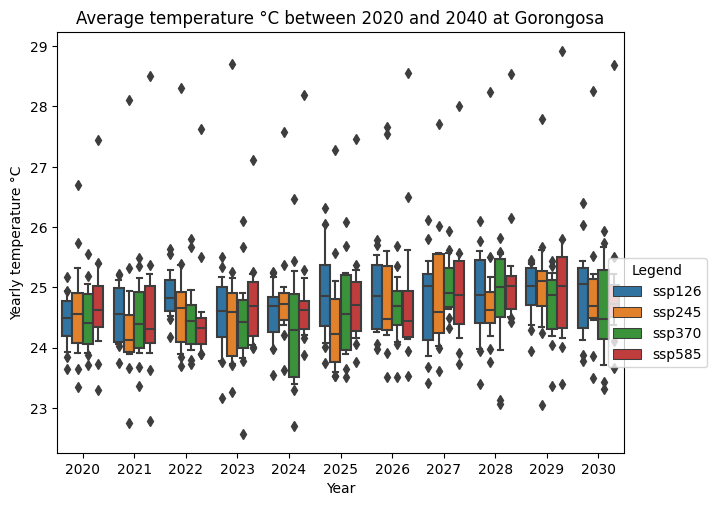

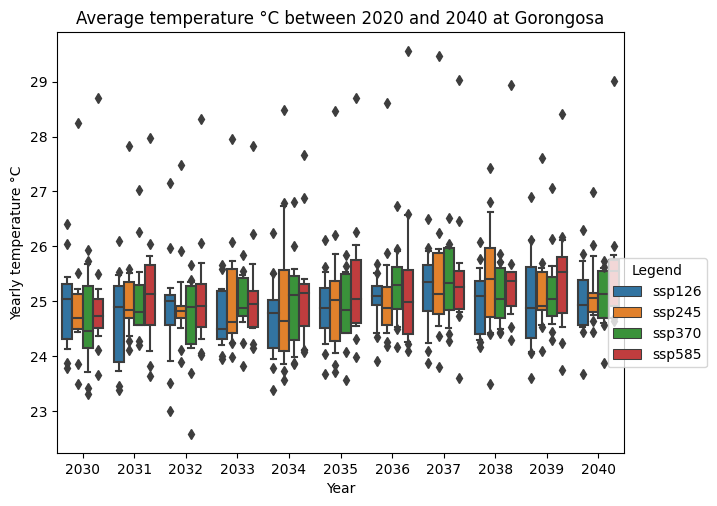

In [107]:
trends_year('tas',tas_future_modeled_NEXGDDPCMIP6[tas_future_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB'],'NEX-GDDP-CMIP6','Average','Gorongosa',2020,2040)

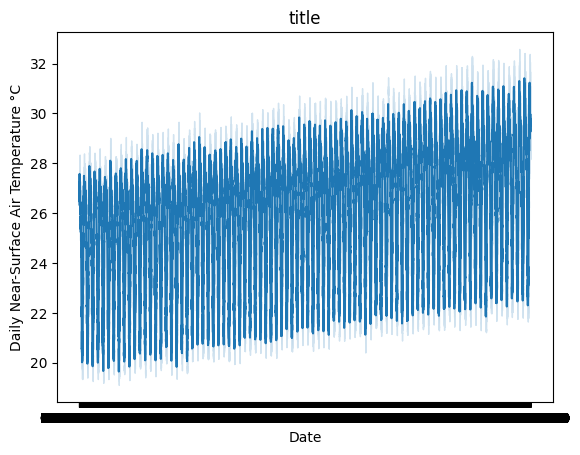

In [108]:
plot_spaghetti(tas_future_modeled_NEXGDDPCMIP6[tas_future_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB'],'Date','Daily Near-Surface Air Temperature °C','title','Yes')

In [109]:
tas_future_modeled_NEXGDDPCMIP6_gorongosa=tas_future_modeled_NEXGDDPCMIP6[tas_future_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB'].drop(['Name project','Latitude','Longitude'],axis=1).groupby(['Experiment','Model','Year'])[['Daily Near-Surface Air Temperature °C']].mean().reset_index()

In [ ]:
tas_future_modeled_NEXGDDPCMIP6_gorongosa

In [ ]:
g = sns.FacetGrid(tas_future_modeled_NEXGDDPCMIP6_gorongosa, col="Experiment", height=4, aspect=.5)
g.map(sns.lineplot, "Year",'Daily Near-Surface Air Temperature °C')

In [ ]:
sns.lineplot(data=tas_future_modeled_NEXGDDPCMIP6_gorongosa, x="Year",y='Daily Near-Surface Air Temperature °C',hue='Experiment')

In [ ]:
tas_future_modeled_NEXGDDPCMIP6_gorongosa_overMandS=tas_future_modeled_NEXGDDPCMIP6[tas_future_modeled_NEXGDDPCMIP6['Name project']=='Gorongosa_EIB'].drop(['Name project','Latitude','Longitude'],axis=1).groupby(['Year'])[['Daily Near-Surface Air Temperature °C']].mean().reset_index()

In [ ]:
sns.lineplot(tas_future_modeled_NEXGDDPCMIP6,x='Year',y='Daily Near-Surface Air Temperature °C')

In [ ]:
plot_spaghetti(tas_future_modeled_NEXGDDPCMIP6,'Year','Daily Near-Surface Air Temperature °C','title','No')

In [ ]:
tas_historic_modeled_NEXGDDPCMIP6_gorongosa

In [ ]:
fig,ax=plt.subplots() # sans aire
sns.lineplot(data=tas_historic_modeled_NEXGDDPCMIP6_gorongosa,x= 'Month',y='Daily Near-Surface Air Temperature °C',hue='Model',ax=ax)#,errorbar=('pi',50) )
sns.lineplot(data=daily_sum_obs_from_NOAA_gorongosa,x='Month',y='TAVG',color='black',ax=ax)

In [ ]:
fig,ax=plt.subplots() # sans aire
sns.lineplot(data=tas_historic_modeled_NEXGDDPCMIP6_gorongosa,x= 'Year',y='Daily Near-Surface Air Temperature °C',hue='Model',ax=ax)#,errorbar=('pi',50) )
sns.lineplot(data=daily_sum_obs_from_NOAA_gorongosa,x='Year',y='TAVG',color='black',ax=ax)

In [ ]:
sns.lineplot(data=na_values,y='TAVG',x='Year')

In [ ]:
daily_sum_obs_from_NOAA_gorongosa['TAVG']